In [1]:
# --- Imports & setup ---
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import load_model

In [2]:
keras.backend.set_floatx('float32')
tf.random.set_seed(1234)
np.random.seed(1234)

In [3]:
# --- Load dataset ---

# mode = "PRICE"
mode = "IV"

if mode=='PRICE':
    dataset = np.load('heston_data/Heston_ql_LHS_Feller_CALL_r_0.0_T_K_20k.npy')
else:
    dataset = np.load('heston_data/Heston_ql_LHS_Feller_IV_r_0.0_T_K_20k.npy')
    
print("dataset shape:", dataset.shape)

dataset shape: (20000, 93)


In [4]:
# Columns: [5 params | 88 outputs]
param_names = ['v0', 'rho', 'sigma', 'theta', 'kappa']

X_all = dataset[:, :5]   # inputs (features): parameters
y_all = dataset[:, 5:]   # targets (labels): 88-dim outputs

print("X_all shape (N,5):", X_all.shape)
print("y_all shape (N,88):", y_all.shape)
# assert y_all.shape[1] == 88, "Expected 88 outputs per row."

# Replace all negative values with NaN
y_all[y_all < 0] = np.nan

print("y min/max:", np.min(y_all), np.max(y_all))
print("Negative y:", np.sum(y_all <= 0))
print("NaN y:", np.isnan(y_all).sum())

for i, name in enumerate(param_names):
    col = X_all[:, i]
    print(f"{name}: min = {col.min()}, max = {col.max()}")

X_all shape (N,5): (20000, 5)
y_all shape (N,88): (20000, 88)
y min/max: 1e-06 0.5026301
Negative y: 0
NaN y: 0
v0: min = 0.0001068579003913328, max = 0.039990946650505066
rho: min = -0.9497585296630859, max = -0.10005661100149155
sigma: min = 0.010118654929101467, max = 0.999904453754425
theta: min = 0.013464909046888351, max = 0.1999940723180771
kappa: min = 1.0257070064544678, max = 9.999472618103027


In [5]:
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

In [6]:
# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size=0.20, 
                                                    random_state=42)

print("Train shapes:", X_train.shape, y_train.shape)
print("Test  shapes:", X_test.shape,  y_test.shape)

Train shapes: (16000, 5) (16000, 88)
Test  shapes: (4000, 5) (4000, 88)


In [7]:
# --- INPUT scaling: X (params) -> [-1, 1] ---
X_lb = X_all.min(axis=0)
X_ub = X_all.max(axis=0)

X_mid = 0.5 * (X_ub + X_lb)
X_span = (X_ub - X_lb)

def scale_X(x):
    """Scale parameters to [-1,1]."""
    return (x - X_mid) * (2.0 / X_span)

def inverse_X(x_scaled):
    """Inverse scaling: recover params in original units."""
    return x_scaled * (X_span / 2.0) + X_mid

X_train_scaled = scale_X(X_train)
X_test_scaled  = scale_X(X_test)

# # --- OUTPUT scaling: y (prices) -> N(0,1) with StandardScaler ---
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled  = y_scaler.transform(y_test)

def inverse_y(y_scaled):
    """Inverse scaling: recover prices in original units."""
    return y_scaler.inverse_transform(y_scaled)

# print("X_train_scaled shape:", X_train_scaled.shape)
# print("y_train_scaled shape:", y_train_scaled.shape)

param_names = ['v0', 'rho', 'sigma', 'theta', 'kappa']

print([f" {p}" for p in param_names])
print([f"{p:.5f}" for p in X_lb])
print([f"{p:.5f}" for p in X_ub])


[' v0', ' rho', ' sigma', ' theta', ' kappa']
['0.00011', '-0.94976', '0.01012', '0.01346', '1.02571']
['0.03999', '-0.10006', '0.99990', '0.19999', '9.99947']


In [8]:
# --- Custom RMSE loss ---
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

if mode=='PRICE':
    modelGEN = load_model('Heston_ql_CALL_full_model.h5',
                      custom_objects={'root_mean_squared_error': root_mean_squared_error})
else:
    modelGEN = load_model('Heston_ql_IV_full_model.h5',
                      custom_objects={'root_mean_squared_error': root_mean_squared_error})



True params: [ 0.02016153 -0.57195693  0.32032037  0.11817408  9.547848  ]


2025-09-12 01:01:28.741803: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


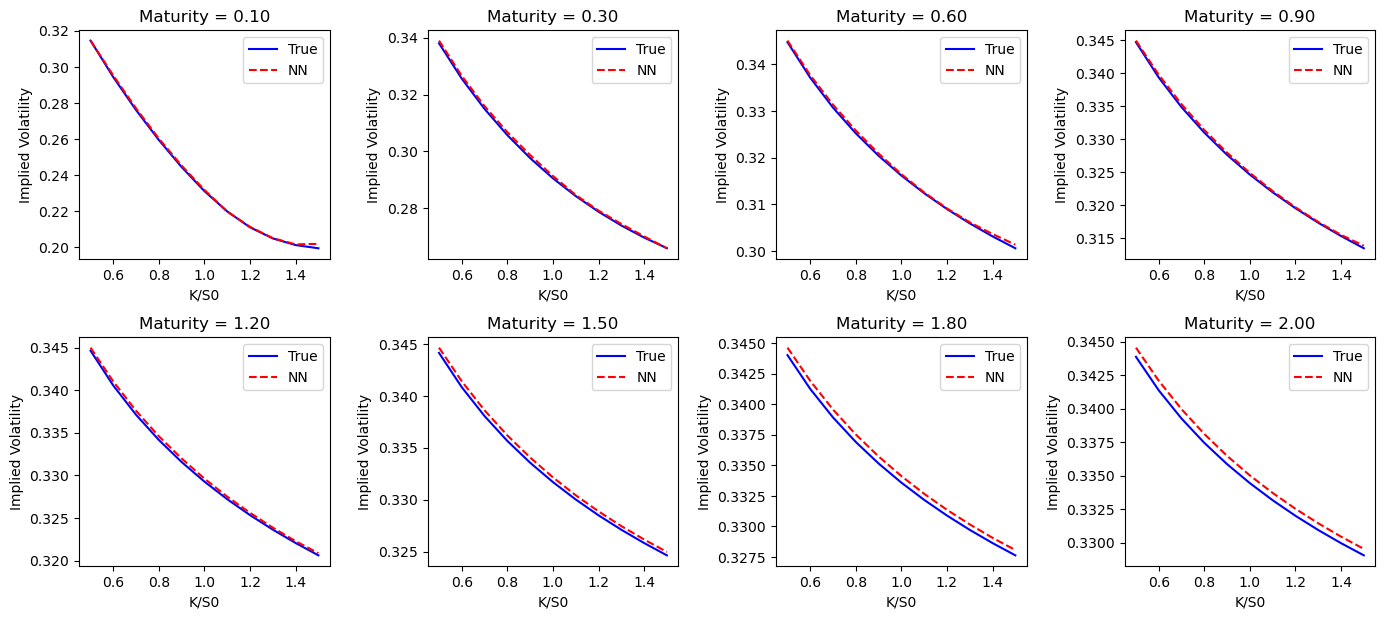

In [9]:
# --- Pick a test sample ---
sample_idx = 2041

# Grid dims
S0 = 1.0
strikes_dim = len(strikes)
maturities_dim = len(maturities)

# True inputs/outputs (original units)
params_true  = X_test[sample_idx]       # shape (5,)
surface_true = y_test[sample_idx]       # shape (88,)

print("True params:", params_true)

# --- Predict with the trained model ---
params_scaled   = scale_X(params_true.reshape(1, -1))     # [-1, 1]
pred_scaled     = modelGEN.predict(params_scaled, verbose=0)
surface_pred    = inverse_y(pred_scaled)[0]               # back to original units

# --- Plot strike slices for each maturity ---
plt.figure(figsize=(14, 12))
for i, T in enumerate(maturities):
    ax = plt.subplot(4, 4, i + 1)
    i0, i1 = i * strikes_dim, (i + 1) * strikes_dim
    ax.plot(strikes / S0, surface_true[i0:i1], 'b', label="True")
    ax.plot(strikes / S0, surface_pred[i0:i1], '--r', label="NN")
    ax.set_title(f"Maturity = {T:.2f}")
    ax.set_xlabel("K/S0")
    if mode=='PRICE':
        ax.set_ylabel("Call Price")
    else:
        ax.set_ylabel("Implied Volatility")
    ax.legend()

plt.tight_layout()
# plt.savefig("HestonNN_SurfaceExample.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()


In [10]:
from heston.QuantlibHeston import heston_option_price 
from BlackScholes.BSprice import implied_volatility

In [11]:
def generate_price(S0, r, strikes, maturities, true_params, option_type="call"):
    """Generate prices from QuantLib Heston model """
    
    market_prices = []
    
    for T in maturities:
        row = []
        for K in strikes:
            
            price = heston_option_price(
                S0, K, r, 0.0, T,
                true_params["v0"],
                true_params["kappa"],
                true_params["theta"],
                true_params["sigma"],
                true_params["rho"],
                option_type=option_type)
            
            row.append(price)
        market_prices.append(row)
    return np.array(market_prices)

def generate_iv(S0, r, strikes, maturities, true_params, option_type="call"):
    """Generate prices from QuantLib Heston model """
    
    market_prices = []
    
    for T in maturities:
        row = []
        for K in strikes:
            
            price = heston_option_price(
                S0, K, r, 0.0, T,
                true_params["v0"],
                true_params["kappa"],
                true_params["theta"],
                true_params["sigma"],
                true_params["rho"],
                option_type=option_type
            )
            
            iv = implied_volatility(price, S0, K, T, r, q=0, option_type=option_type)

            row.append(iv)
        market_prices.append(row)
    return np.array(market_prices)

In [12]:
def check_feller(params, verbose=True):
    """
    Check the Feller condition for the Heston variance process:
        2 * kappa * theta > sigma^2
    """
    kappa = params["kappa"]
    theta = params["theta"]
    sigma = params["sigma"]

    fel_cond = 2*kappa*theta/(sigma**2)

    if verbose:
        if fel_cond>=1:
            print("Feller condition HOLDS", fel_cond)
        else:
            print("Feller condition VIOLATED", fel_cond)

    return fel_cond

In [ ]:
def compare_custom_params_with_prediction(S0, r, strikes, maturities, custom_params, model, scale_X, inverse_y, mode):

    strikes_dim = len(strikes)
    maturities_dim = len(maturities)

    # Generate market prices for custom params (shape: maturities x strikes)

    if mode=='PRICE':
        true_prices = generate_price(S0, r, strikes, maturities, custom_params, option_type='call')
    else:
        true_prices = generate_iv(S0, r, strikes, maturities, custom_params, option_type="call")
    
    # Prepare model input vector in the expected order (v0, rho, sigma, theta, kappa)
    param_vector = np.array([
        custom_params["v0"],
        custom_params["rho"],
        custom_params["sigma"],
        custom_params["theta"],
        custom_params["kappa"]
    ]).reshape(1, -1)
    
    # Scale input parameters for the model input
    param_vector_scaled = scale_X(param_vector)
    
    # Predict scaled prices with the model, then invert scaling back to original units
    pred_scaled = model.predict(param_vector_scaled, verbose=0)
    pred_prices = inverse_y(pred_scaled)[0].reshape(maturities_dim, strikes_dim)

    

    # Plot strike slices for each maturity: true prices vs predicted prices
    plt.figure(figsize=(14, 12))
    for i, T in enumerate(maturities):
        ax = plt.subplot(4, 4, i + 1)
        i0, i1 = i, i + 1
        # Plotting the row (maturity) from true and predicted price grids
        # ax.plot(np.log(strikes / S0), true_prices[i], 'b', label="True")
        # ax.plot(np.log(strikes / S0), pred_prices[i], '--r', label="NN")

        ax.plot(strikes / S0, true_prices[i], 'o-b', label="True")
        ax.plot(strikes / S0, pred_prices[i], 'h--r', label="NN")

        ax.set_title(f"Maturity = {T:.2f}")
        ax.set_xlabel("K/S0")
        if mode=='PRICE':
            ax.set_ylabel("Call Price")
        else:
            ax.set_ylabel("Implied Volatility")

        ax.legend()

    plt.tight_layout()
    plt.show()
    
    # Compute and print RMSE between true and predicted surfaces
    rmse = np.sqrt(np.mean((pred_prices - true_prices) ** 2))
    print(f"RMSE between true and predicted prices: {rmse:.6f}")


Feller condition HOLDS 2.0403857557504446


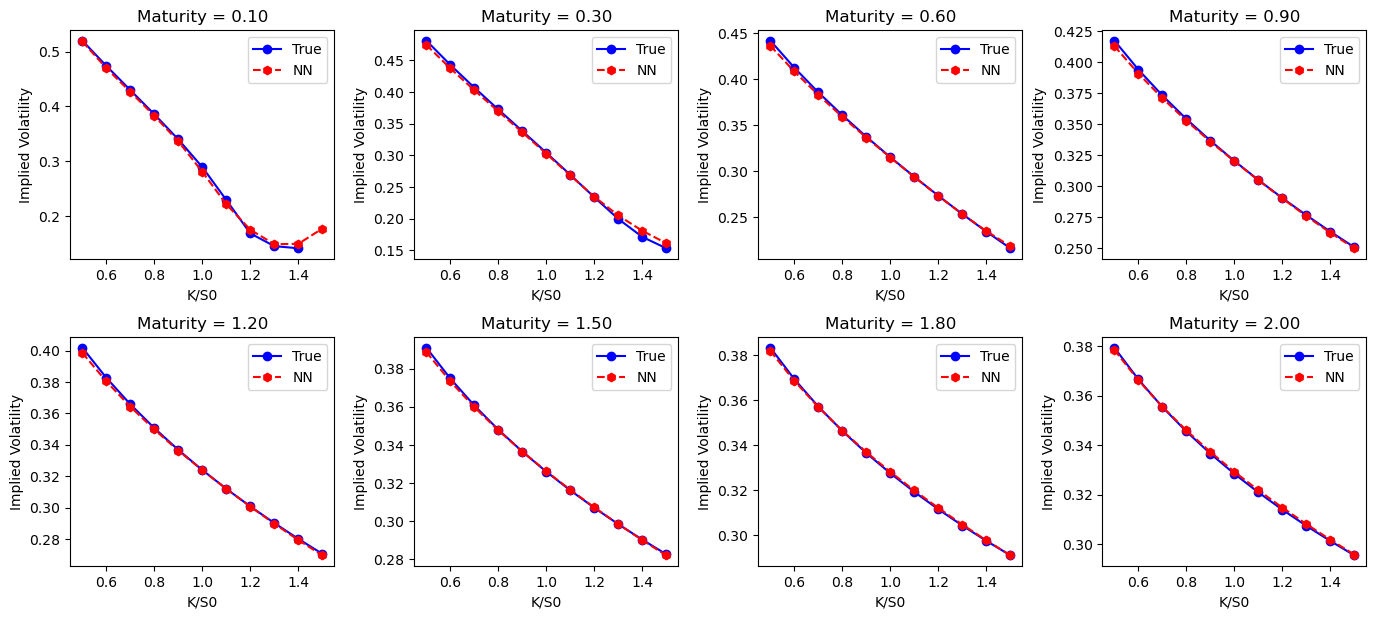

RMSE between true and predicted prices: nan


In [20]:
custom_params = {
    "kappa": 6.81,
    "theta": 0.12,
    "sigma": 0.895,
    "rho": -0.92,
    "v0": 0.079
}

# [' v0', ' rho', ' sigma', ' theta', ' kappa']
# ['0.00011', '-0.94976', '0.01012', '0.01346', '1.02571']
# ['0.03999', '-0.10006', '0.99990', '0.19999', '9.99947']

# 0.01799103 -0.29271735  0.89585693  0.12036402  7.8141966

check_feller(custom_params)

compare_custom_params_with_prediction(
    S0=1.0,
    r=0.0,
    strikes=strikes,
    maturities=maturities,
    custom_params=custom_params,
    model=modelGEN,
    scale_X=scale_X,
    inverse_y=inverse_y, mode=mode
)


In [30]:



true_prices = generate_iv(1.0, 0.0, strikes, maturities, custom_params, option_type="call")

# Prepare model input vector in the expected order (v0, rho, sigma, theta, kappa)
param_vector = np.array([
    custom_params["v0"],
    custom_params["rho"],
    custom_params["sigma"],
    custom_params["theta"],
    custom_params["kappa"]
]).reshape(1, -1)

# Scale input parameters for the model input
param_vector_scaled = scale_X(param_vector)

# Predict scaled prices with the model, then invert scaling back to original units
pred_scaled = modelGEN.predict(param_vector_scaled, verbose=0)
pred_prices = inverse_y(pred_scaled)[0].reshape(maturities_dim, strikes_dim)

    

In [32]:
strikes, maturities

(array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 array([0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2. ]))

In [35]:
true_prices

array([[0.52004353, 0.47398755, 0.42979359, 0.3857234 , 0.33985636,
        0.28933895, 0.22937833, 0.16840943, 0.14511775, 0.14120203,
               nan],
       [0.48104037, 0.4427291 , 0.40684888, 0.37230477, 0.33826068,
        0.30404309, 0.26919315, 0.23380218, 0.19954064, 0.17115992,
        0.15323599],
       [0.44188306, 0.4124086 , 0.38564328, 0.36083197, 0.33748182,
        0.31525849, 0.29393552, 0.27337374, 0.25352252, 0.23444117,
        0.21633557],
       [0.41731693, 0.39395001, 0.37312776, 0.35419637, 0.33672736,
        0.32042574, 0.30508212, 0.29054594, 0.2767101 , 0.26350216,
        0.25087945],
       [0.40190922, 0.3827479 , 0.36585526, 0.3506552 , 0.33677033,
        0.32394015, 0.3119778 , 0.30074543, 0.29013938, 0.28008077,
        0.27050943],
       [0.39107847, 0.37488265, 0.36069966, 0.34801912, 0.33650677,
        0.32593159, 0.31612724, 0.30697008, 0.29836595, 0.29024162,
        0.28253934],
       [0.38349198, 0.36948684, 0.35728051, 0.34641616, 0.

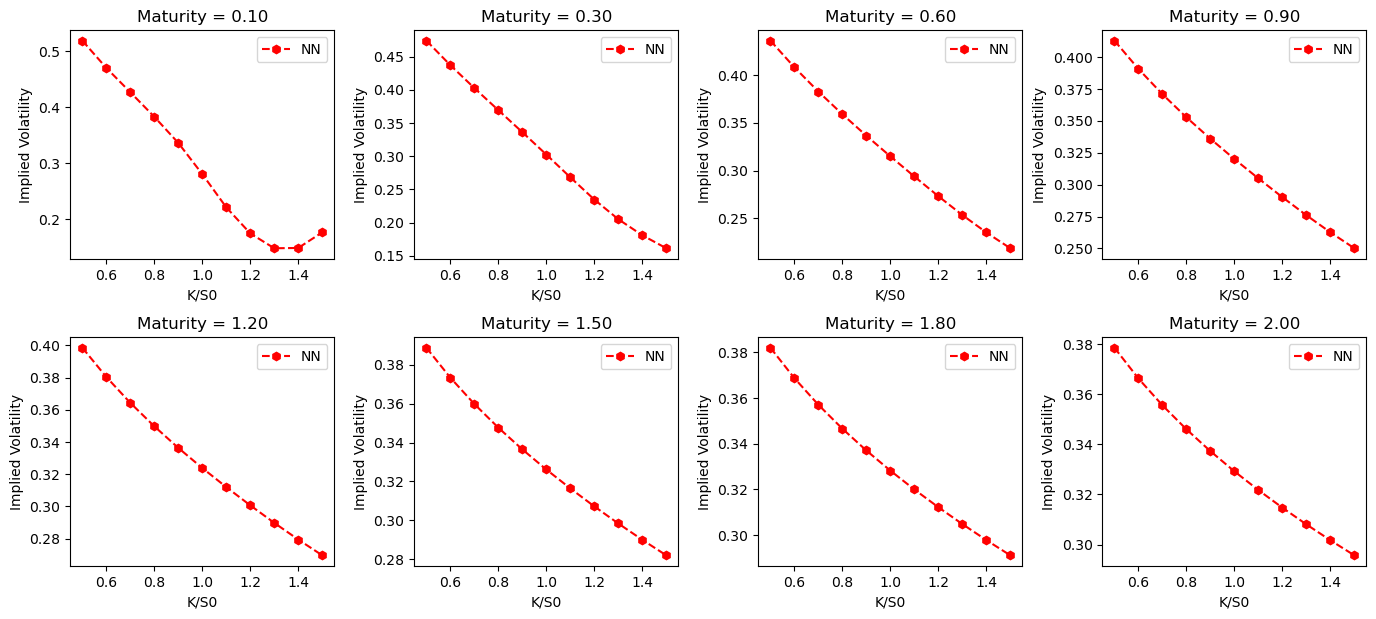

In [34]:
plt.figure(figsize=(14, 12))
for i, T in enumerate(maturities):
    ax = plt.subplot(4, 4, i + 1)
    i0, i1 = i, i + 1
    # Plotting the row (maturity) from true and predicted price grids
    # ax.plot(np.log(strikes / S0), true_prices[i], 'b', label="True")
    # ax.plot(np.log(strikes / S0), pred_prices[i], '--r', label="NN")

    # ax.plot(strikes / S0, true_prices[i], 'o-b', label="True")
    ax.plot(strikes / S0, pred_prices[i], 'h--r', label="NN")

    ax.set_title(f"Maturity = {T:.2f}")
    ax.set_xlabel("K/S0")
    if mode=='PRICE':
        ax.set_ylabel("Call Price")
    else:
        ax.set_ylabel("Implied Volatility")

    ax.legend()

plt.tight_layout()
plt.show()